## Test the tfrecord and provider for ICDAR_test

In [4]:
import numpy as np 
import os, os.path
import sys
#sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__),'..')))
sys.path.insert(0,'/Users/kiyoshi/Desktop/Research/LAB/FirstAccessment/2ndPaper/Textbox-Tensor/')
import tensorflow as tf 
import re
from datasets_test.dataset_utils import int64_feature, float_feature, bytes_feature ,ImageCoder, norm
import cv2
import skimage.io as skio
from matplotlib import pyplot as plt

In [5]:
ground_truth_path = '/Users/kiyoshi/Desktop/Research/LAB/FirstAccessment/2ndPaper/Textbox-Tensor/ICDAR-Test-GT/'
# Change this path to the directory of the image files
image_path = '/Users/kiyoshi/Desktop/Research/LAB/FirstAccessment/2ndPaper/Textbox-Tensor/ICDAR-Test-Images/'

In [6]:
def readGT(gt_dir):
    #create structure for the columns
    gt_coordinate_and_words = []
    gt_names = []
    path_list = []
    txt_name_list = []

    # Save the paths for all gound truth txt files
    for txt_name in os.listdir(gt_dir):
        txt_path = ground_truth_path + txt_name
        txt_name_list.append(txt_name)
        path_list.append(txt_path)
    #print path_list

    # Only include the txt paths with right contents
    """
    for path in path_list:
        file_content = open(path,'rU').readlines()
        number_of_elements = 0
        for lines in file_content:
            lines = lines.strip()
            elements_in_a_line = lines.split(",")    		
            number_of_elements += len(elements_in_a_line)

        if number_of_elements % 5 == 0:
            true_path_list.append(path)

    print true_path_list
    """

    for file_path in path_list:
        try:
            gt_file = np.loadtxt(file_path, dtype={'names':('xmin','ymin','xmax','ymax','word'),'formats':(np.float, np.float, np.float, np.float, '|S15')}, delimiter = ',')
            gt_coordinate_and_words.append(gt_file)
            #true_path_list.append(file_path)

            # Save image names
            #for image_name in txt_name_list: 
            image_name = os.path.basename(file_path)
            if len(image_name) == 12:
                imname = image_name[3:8] + '.jpg'
            if len(image_name) == 13:
                imname = image_name[3:9] + '.jpg'
            if len(image_name) == 14:
                imname = image_name[3:10] +'.jpg'
            gt_names.append(imname)
        except ValueError:
            continue
    #print gt_coordinate_and_words[1][:]
    #print gt_names

    return gt_names, gt_coordinate_and_words

In [7]:
def _convert_to_example(image_data, shape, bbox, label, imname):
    nbbox = np.array(bbox)
    ymin = list(nbbox[:, 0])
    xmin = list(nbbox[:, 1])
    ymax = list(nbbox[:, 2])
    xmax = list(nbbox[:, 3])

    """
    print ymin
    print xmin
    print ymax
    print xmax
    """
    print 'shape:{}, height:{}, width:{}'.format(shape, shape[0], shape[1])
    example = tf.train.Example(features=tf.train.Features(feature={
            'image/height': int64_feature(shape[0]),
            'image/width': int64_feature(shape[1]),
            'image/channels': int64_feature(shape[2]),
            'image/shape': int64_feature(shape),
            'image/object/bbox/ymin': float_feature(ymin),
            'image/object/bbox/xmin': float_feature(xmin),
            'image/object/bbox/ymax': float_feature(ymax),
            'image/object/bbox/xmax': float_feature(xmax),
            'image/object/bbox/label': int64_feature(label),
            'image/format': bytes_feature('jpeg'),
            'image/encoded': bytes_feature(image_data),
            'image/name': bytes_feature(imname),
            }))
    #print example
    return example


In [8]:
def _image_processing(wordbb, imname, coder):
    # Read image according to the imname
    imname_path = image_path + imname
    image_data = tf.gfile.GFile(imname_path, 'r').read()
    image = coder.decode_jpeg(image_data)
    shape = image.shape

    # The number of boxes in an image
    bbox = []

    ymin = wordbb['ymin']
    xmin = wordbb['xmin']
    ymax = wordbb['ymax']
    xmax = wordbb['xmax']
    """
    ymin = np.maximum(ymin/shape[0], 0.0)
    xmin = np.maximum(xmin/shape[1], 0.0)
    ymax = np.minimum(ymax/shape[0], 1.0)
    xmax = np.minimum(xmax/shape[1], 1.0)
    """
    try:
        number_of_boxes = wordbb.shape[0]
    except IndexError:
        number_of_boxes = 1

    if (number_of_boxes == 1):
        bbox = [[ymin,xmin,ymax,xmax]]
    else:
        bbox = [[ymin[i],xmin[i],ymax[i],xmax[i]] for i in range(number_of_boxes)] 

    label = [1 for i in range(number_of_boxes)]
    shape = list(shape)

    #print bounding_box

    return image_data, shape, bbox, label, imname

In [9]:
def main():
    # Get gt_names and gt_coordinate_and_words
    gt_names, gt_coordinate_and_words = readGT(ground_truth_path)
    coder = ImageCoder()
    tf_filename = 'ICDAR2013_Test.tfrecord'
    tfrecord_writer = tf.python_io.TFRecordWriter(tf_filename)
    # Generate index and shuffle
    index = [i for i in range(len(gt_names))]
    random_index = np.random.permutation(index)
    # Deal with every image
    for i in range(5) :
        imname = gt_names[i]
        wordbb = gt_coordinate_and_words[i]
        #print wordbb
        image_data, shape, bbox, label, imname = _image_processing(wordbb, imname, coder)
        print bbox
        print imname
        #example = _convert_to_example(image_data, shape, bbox, label, imname)
        #tfrecord_writer.write(example.SerializeToString())
        #print i
        bbox = np.array(bbox)
        y_min = list(bbox[:,0])
        x_min = list(bbox[:,1])
        y_max = list(bbox[:,2])
        x_max = list(bbox[:,3])

        numOfBox = bbox.shape[0]
        im_path = image_path + imname
        img = cv2.imread(im_path, 0)

        for i in range (numOfBox):
            dst_image = cv2.rectangle(np.uint8(img),(int(x_min[i]),int(y_min[i])),
                         (int(x_max[i]),int(y_max[i])),(255,0,0))

        skio.imshow(dst_image)
        skio.show()

[[43.0, 38.0, 215.0, 920.0], [264.0, 275.0, 450.0, 665.0], [699.0, 0.0, 830.0, 77.0], [705.0, 128.0, 839.0, 483.0], [710.0, 542.0, 841.0, 938.0], [884.0, 87.0, 1021.0, 457.0], [919.0, 517.0, 1024.0, 831.0], [1095.0, 166.0, 1231.0, 468.0], [1069.0, 530.0, 1206.0, 743.0]]
img_1.jpg


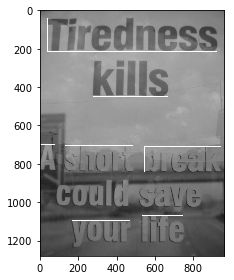

[[315.0, 1029.0, 382.0, 1227.0], [313.0, 1256.0, 367.0, 1452.0], [398.0, 1034.0, 470.0, 1269.0], [389.0, 1292.0, 451.0, 1552.0], [378.0, 1580.0, 441.0, 1757.0], [908.0, 1074.0, 1098.0, 2396.0], [1155.0, 1085.0, 1262.0, 1200.0], [1070.0, 1247.0, 1248.0, 2065.0], [2190.0, 2313.0, 2284.0, 2608.0]]
img_10.jpg


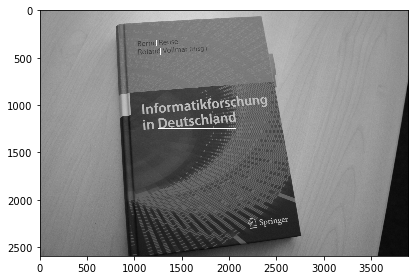

[[150.0, 693.0, 187.0, 746.0], [167.0, 754.0, 211.0, 819.0], [199.0, 706.0, 228.0, 765.0], [222.0, 774.0, 242.0, 809.0], [570.0, 149.0, 688.0, 697.0], [700.0, 147.0, 775.0, 701.0]]
img_100.jpg


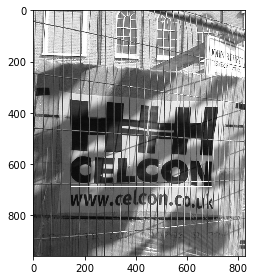

[[347.0, 185.0, 404.0, 283.0], [439.0, 103.0, 518.0, 366.0]]
img_101.jpg


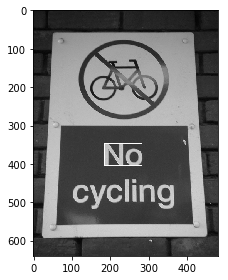

[[295.0, 18.0, 346.0, 254.0], [302.0, 283.0, 351.0, 441.0], [350.0, 125.0, 376.0, 327.0], [357.0, 339.0, 381.0, 430.0]]
img_102.jpg


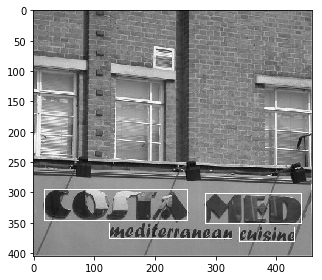

In [10]:
main()